### Install required dependencies:
e.g. pip

python -m pip install pyzmq

python -m pip install cbor

Setting path not necessary, zmqRemoteApi folder is copied into sample folder already (Simulator version 4.4.)
~~export PYTHONPATH=/path/to/zmqRemoteApi/clients/python~~

In [8]:
#import required packages
import time
from zmqRemoteApi import RemoteAPIClient

import numpy as np
import matplotlib.pyplot as plt

import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow as tf

import tqdm

from utils import normalize, closedLoop

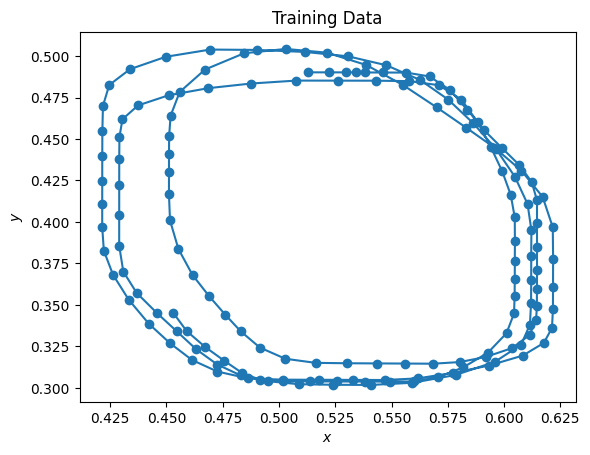

In [46]:
data = np.load('data/circle.npz')

dsFactor = 3

initialOffset = 150

# Manually normalize, since I know the scale of the data a priori
xArr = data["positions"][initialOffset::dsFactor,0] / np.pi
yArr = data["positions"][initialOffset::dsFactor,1] / np.pi

xArr = xArr[:len(xArr)//4]
yArr = yArr[:len(yArr)//4]

plt.plot(xArr, yArr, '-o')
plt.title('Training Data')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

In [47]:
model = keras.Sequential()

model.add(layers.SimpleRNN(15, input_dim=2, return_sequences=True, activation='sigmoid'))
model.add(layers.Dense(2, activation='sigmoid'))

model.compile(loss='mse', optimizer=keras.optimizers.Adam(1e-3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, None, 15)          270       
                                                                 
 dense_2 (Dense)             (None, None, 2)           32        
                                                                 
Total params: 302
Trainable params: 302
Non-trainable params: 0
_________________________________________________________________


In [48]:
numEpochs = 2000

# These have a slightly different shape than in the homebrewed network, notably
# with an extra dimension in the middle. This doesn't actually change the amount
# of information provided, and any two arrays can easily be flipped with
# elmanArr = kerasArr[:,0,:]
# kerasArr = np.reshape(elmanArr, (elmanArr.shape[0], 1, elmanArr.shape[1]))
inputArr = np.reshape(np.array(list(zip(xArr, yArr)))[:-1], (1, len(xArr)-1, 2))
targetArr = np.reshape(np.array(list(zip(xArr, yArr)))[1:], (1, len(xArr)-1, 2))

print(np.shape(inputArr))
print(np.shape(targetArr))

errorArr = model.fit(inputArr, targetArr, epochs=numEpochs).history["loss"]

(1, 158, 2)
(1, 158, 2)
Epoch 1/2000
1/1 [==============================] - 0s 413ms/step - loss: 0.0594
Epoch 2/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.0582
Epoch 3/2000
1/1 [==============================] - 0s 16ms/step - loss: 0.0569
Epoch 4/2000
1/1 [==============================] - 0s 14ms/step - loss: 0.0557
Epoch 5/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.0545
Epoch 6/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.0534
Epoch 7/2000
1/1 [==============================] - 0s 16ms/step - loss: 0.0522
Epoch 8/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.0510
Epoch 9/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.0499
Epoch 10/2000
1/1 [==============================] - 0s 16ms/step - loss: 0.0487
Epoch 11/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.0476
Epoch 12/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.0465
Epoch 13/200

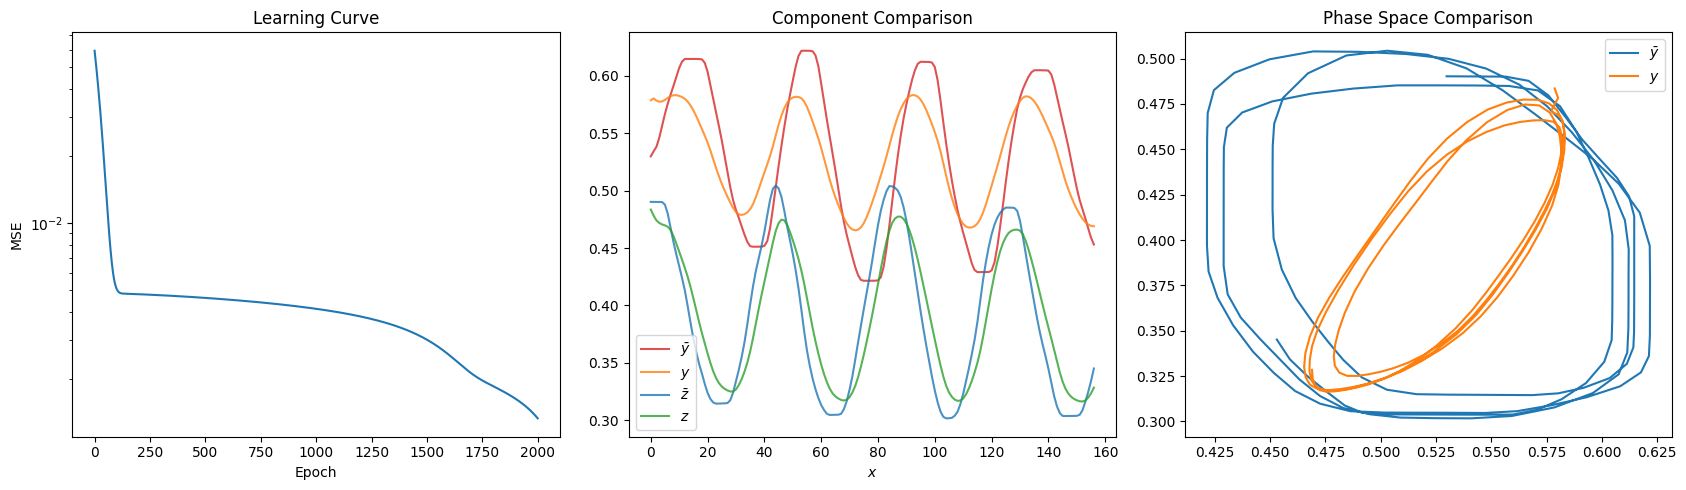

In [50]:
fig = plt.figure(figsize=(17,5))

ax = [None, None, None]
ax[0] = fig.add_subplot(1, 3, 1)

ax[0].plot(errorArr)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('MSE')
ax[0].set_yscale('log')
ax[0].set_title('Learning Curve')

ax[1] = fig.add_subplot(1, 3, 2)

outputArr = model(inputArr)

ax[1].plot(targetArr[0,1:,0], alpha=.8, c='tab:red', label=r'$ \bar y $')
ax[1].plot(outputArr[0,1:,0], alpha=.8, c='tab:orange', label='$ y $')
ax[1].plot(targetArr[0,1:,1], alpha=.8, c='tab:blue', label=r'$ \bar z $')
ax[1].plot(outputArr[0,1:,1], alpha=.8, c='tab:green', label='$ z $')
ax[1].legend()
ax[1].set_xlabel('$x$')
ax[1].set_title('Component Comparison')

ax[2] = fig.add_subplot(1, 3, 3)

ax[2].set_title('Phase Space Comparison')
ax[2].plot(targetArr[0,1:,0], targetArr[0,1:,1], label=r'$\bar y$')
ax[2].plot(outputArr[0,1:,0], outputArr[0,1:,1], label=r'$y$')
ax[2].legend()

fig.tight_layout()

#plt.savefig('images/circle_training.png')
plt.show()

In [38]:
def closedLoop(model, x0, nSteps):
    outputArr = np.zeros((1, nSteps+1, x0.shape[-1]))
    outputArr[0,0] = x0
    
    for i in range(nSteps):
        outputArr[:,i+1] = model(outputArr[:,i:i+1])
        
    return outputArr

In [39]:
#open connection to CoppeliaSim, must be running
client = RemoteAPIClient()
sim = client.getObject('sim')

#open scene in the simulator:
import os 
dir_path = os.getcwd()

sim.loadScene(dir_path+'/torobo.ttt')

#we will use synchronous mode, client.step() will perform one simulation step
#otherwise the simulator runs freely, e.g. time can pass between mutliple simulator calls:
#e.g. sending commands to multiple joints may happen at different times
client.setStepping(True)

In [40]:
#Read object ids from scene
hands = [sim.getObject('./tip_left'), sim.getObject('./tip_right')]
rightShoulderJoints = [sim.getObject('./right_arm_joint_1'), sim.getObject('./right_arm_joint_2')]

In [53]:
sim.startSimulation()

handPos = np.zeros((2,len(xArr),3))
tArr = np.zeros(len(xArr))

nSteps = 300
predictArr = closedLoop(model, inputArr[0,0], nSteps)

for i in tqdm.tqdm(range(nSteps)):
    
    sim.setJointTargetPosition(rightShoulderJoints[0], predictArr[0,i,0])
    sim.setJointTargetPosition(rightShoulderJoints[1], predictArr[0,i,1])

    # Read the positions of the hands
    for j in range(2):
        handPos[j,i] = sim.getObjectPosition(hands[j], sim.handle_world)
        
    #next time step ... 
    client.step()
    tArr[i] = sim.getSimulationTime()
    
sim.stopSimulation()

 20%|█████▏                    | 60/300 [00:10<00:40,  5.94it/s]


KeyboardInterrupt: 

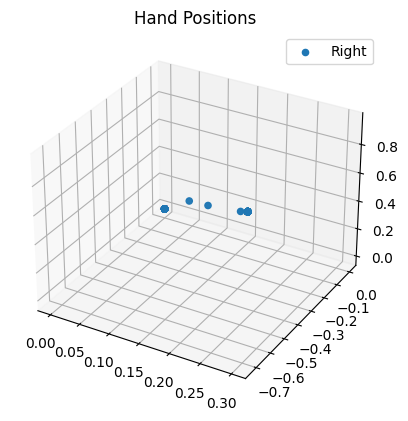

In [54]:
%matplotlib inline

fig = plt.figure()

ax = fig.add_subplot(projection='3d')

#ax.scatter(handPos[0,:,0], handPos[0,:,1], handPos[0,:,2], label='Left')
ax.scatter(handPos[1,:,0], handPos[1,:,1], handPos[1,:,2], label='Right')
ax.set_title('Hand Positions')
#ax.set_xlabel('Time [s]')?
ax.legend()
plt.show()

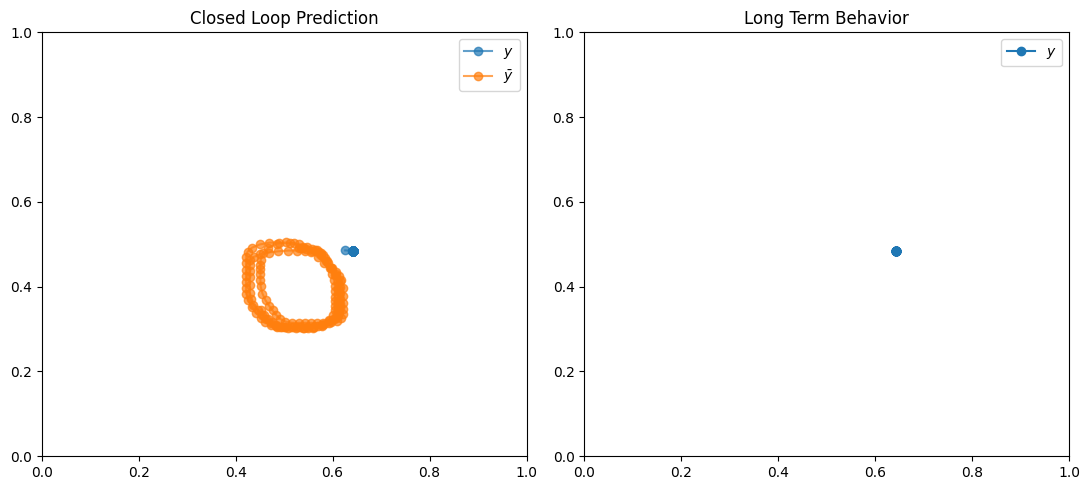

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(11,5))

nSteps = 1000

predictArr = closedLoop(model, inputArr[0,0], nSteps)

ax[0].plot(predictArr[0,1:targetArr.shape[1],0], predictArr[0,1:targetArr.shape[1],1], '-o', alpha=.7, label='$ y $')
ax[0].plot(targetArr[0,1:,0], targetArr[0,1:,1], '-o', alpha=.7, label=r'$\bar y$')
ax[0].legend()
ax[0].set_xlim([0, 1])
ax[0].set_ylim([0, 1])
ax[0].set_title('Closed Loop Prediction')

ax[1].plot(predictArr[0,-nSteps//30:,0], predictArr[0,-nSteps//30:,1], '-o', label='$ y $')
ax[1].legend()
ax[1].set_xlim([0, 1])
ax[1].set_ylim([0, 1])
ax[1].set_title('Long Term Behavior')

fig.tight_layout()
#plt.savefig('images/circle_cl.png')
plt.show()